In [1]:
import train as train
import generate
import eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
BASE_DIR = "./experiments/sanity_check"
PROFILE = "sin-1x"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-1x-10k ======


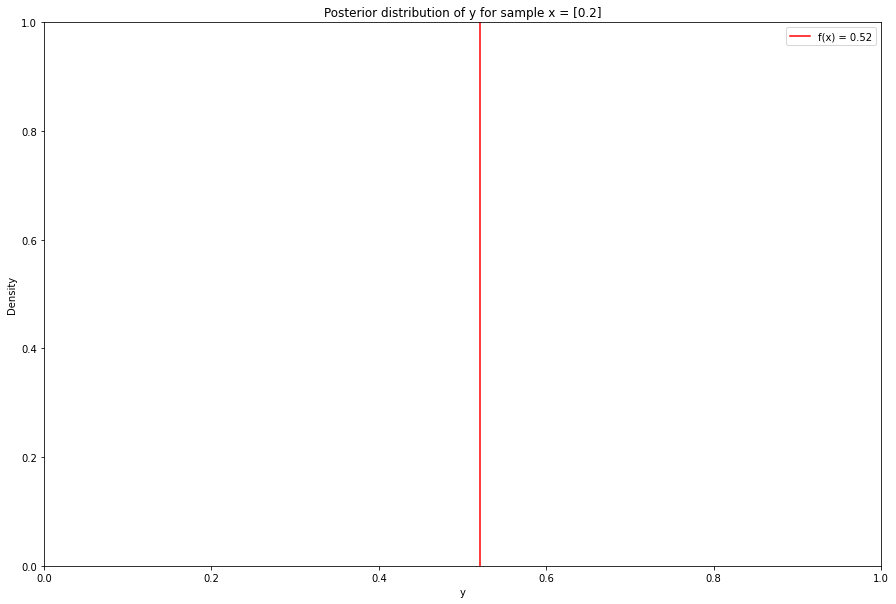

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

In [6]:
x_test[0], y_test[0]

(tensor([-1.3894]), tensor(-1.2968))

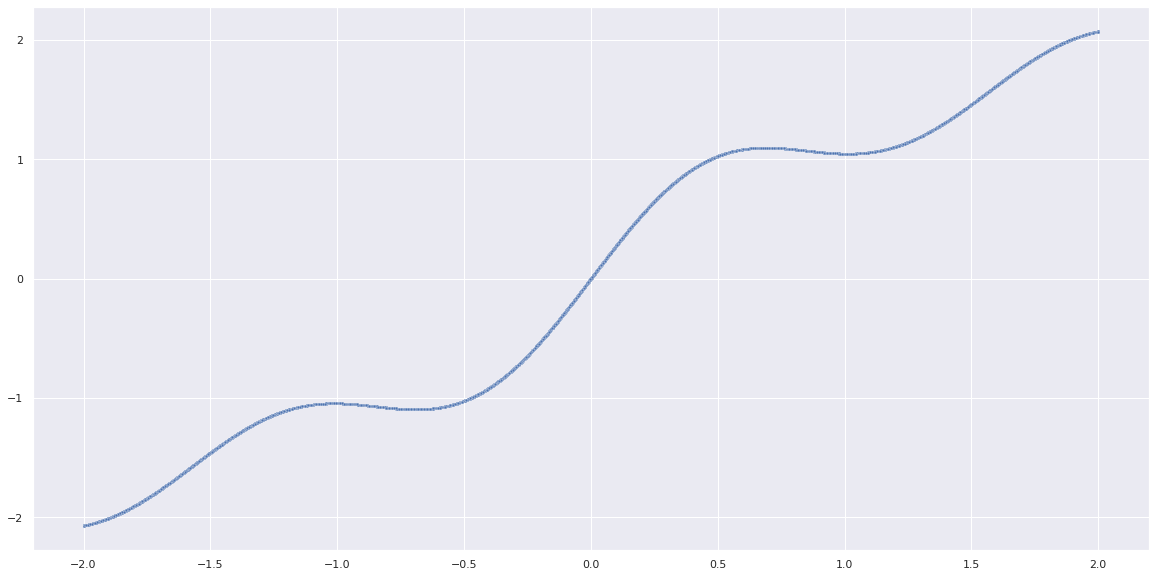

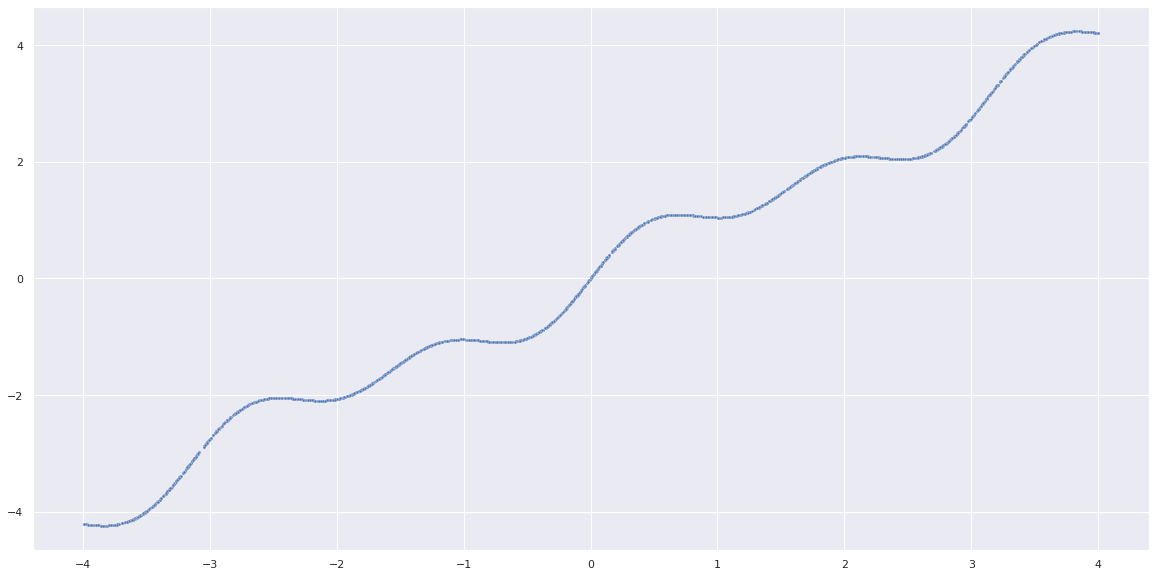

In [7]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_train.flatten(), y=y_train, s=8, ax=ax)
plt.show()
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_test.flatten(), y=y_test, s=8, ax=ax)
plt.show()


In [8]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    infer_model = train.train(config, dataset_config, f"{BASE_DIR}")

RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D
            Trace Shapes:         
             Param Sites:         
            Sample Sites:         
fc.0.0.linear.weight dist   | 32 1
                    value 1 | 32 1
  fc.0.0.linear.bias dist   | 32  
                    value 1 | 32  

In [ ]:
inference_model = eval.load_model(BASE_DIR, config)

Loaded model and parameters from ./experiments/sanity_check/models/sin-1x


In [ ]:
predictive = inference_model.get_predictive(num_predictions=500)
train_samples = predictive(x_train)
train_samples.keys()
test_samples = predictive(x_test)


In [ ]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

train_pred_summary = summary(train_samples)
test_pred_summary = summary(test_samples)

In [ ]:
train_y = train_pred_summary["obs"]
train_mu = train_pred_summary["_RETURN"]
train_predictions = pd.DataFrame({
    "x": x_train.flatten(),
    "mu": train_mu["mean"].flatten(),
    "mu_5": train_mu["5%"].flatten(),
    "mu_95": train_mu["95%"].flatten(),
    "y_mean": train_y["mean"].flatten(),
    "y_5": train_y["5%"].flatten(),
    "y_95": train_y["95%"].flatten(),
    "true_y": y_train.flatten()
})

test_y = test_pred_summary["obs"]
test_mu = test_pred_summary["_RETURN"]
test_predictions = pd.DataFrame({
    "x": x_test.flatten(),
    "mu": test_mu["mean"].flatten(),
    "mu_5": test_mu["5%"].flatten(),
    "mu_95": test_mu["95%"].flatten(),
    "y_mean": test_y["mean"].flatten(),
    "y_5": test_y["5%"].flatten(),
    "y_95": test_y["95%"].flatten(),
    "true_y": y_test.flatten()
})


In [ ]:
train_predictions.head()

,x,mu,mu_5,mu_95,y_mean,y_5,y_95,true_y
0,0.195254,0.155457,-4.416575,4.526308,0.165246,-4.679595,4.951448,0.520652
1,0.860757,0.830757,-3.873053,5.273515,0.808235,-4.830047,5.861833,1.068289
2,0.411054,0.380429,-4.261307,4.789035,0.495834,-4.518506,5.500949,0.930020
3,0.179533,0.139026,-4.427849,4.512170,0.103506,-4.974929,5.262011,0.482346
4,-0.305381,-0.370342,-4.946525,3.907697,-0.327088,-5.371952,4.667609,-0.759315


In [ ]:
train_pred_sorted = train_predictions.sort_values(by='x')
test_pred_sorted = test_predictions.sort_values(by='x')

def plot_predictions(summary):
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['mu'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['mu_5'], y2=summary['mu_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)
    
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['y_mean'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['y_5'], y2=summary['y_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)

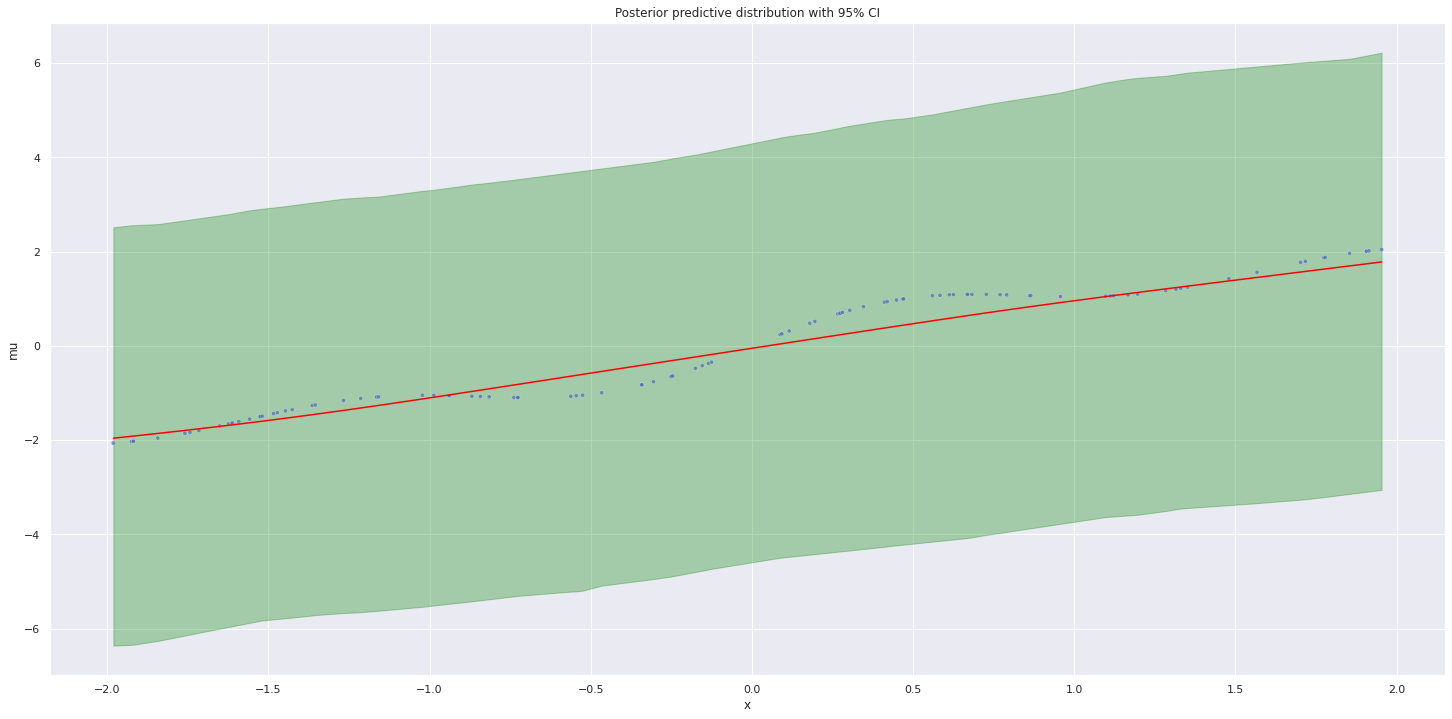

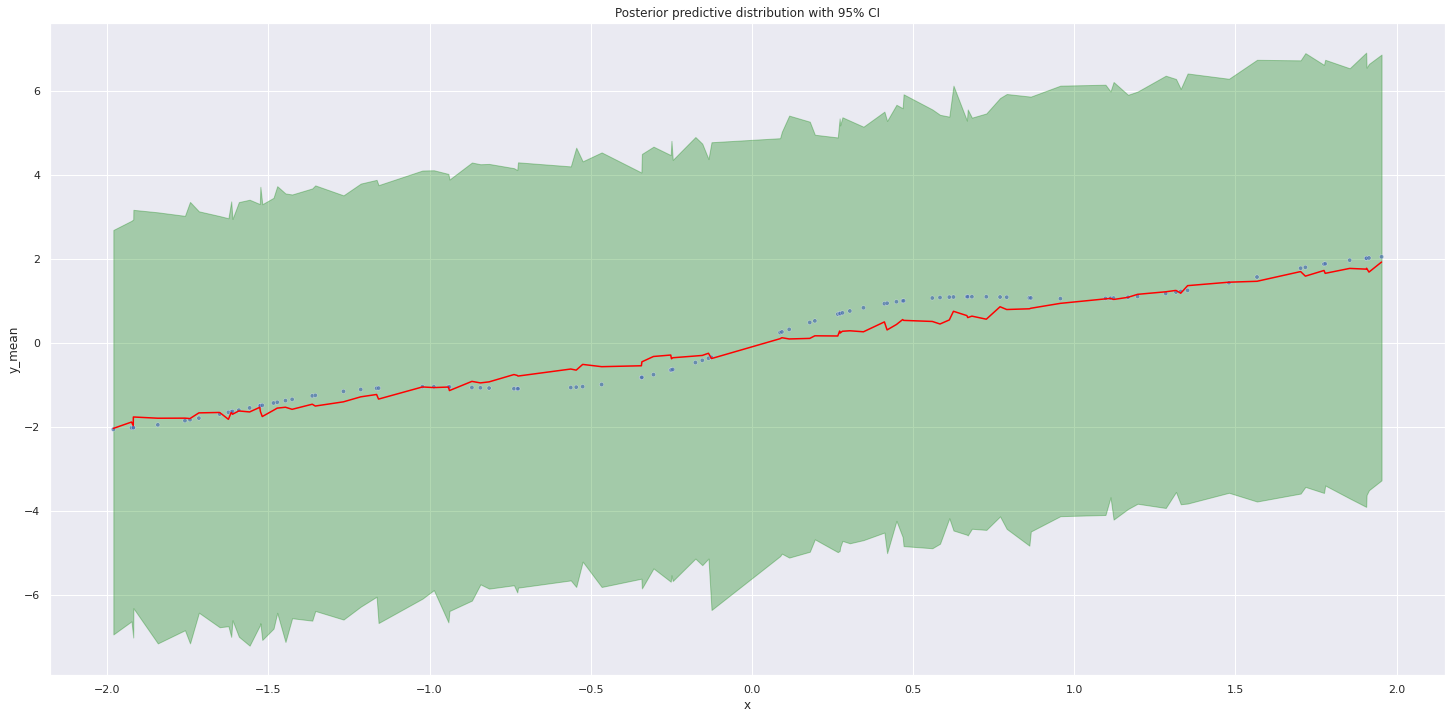

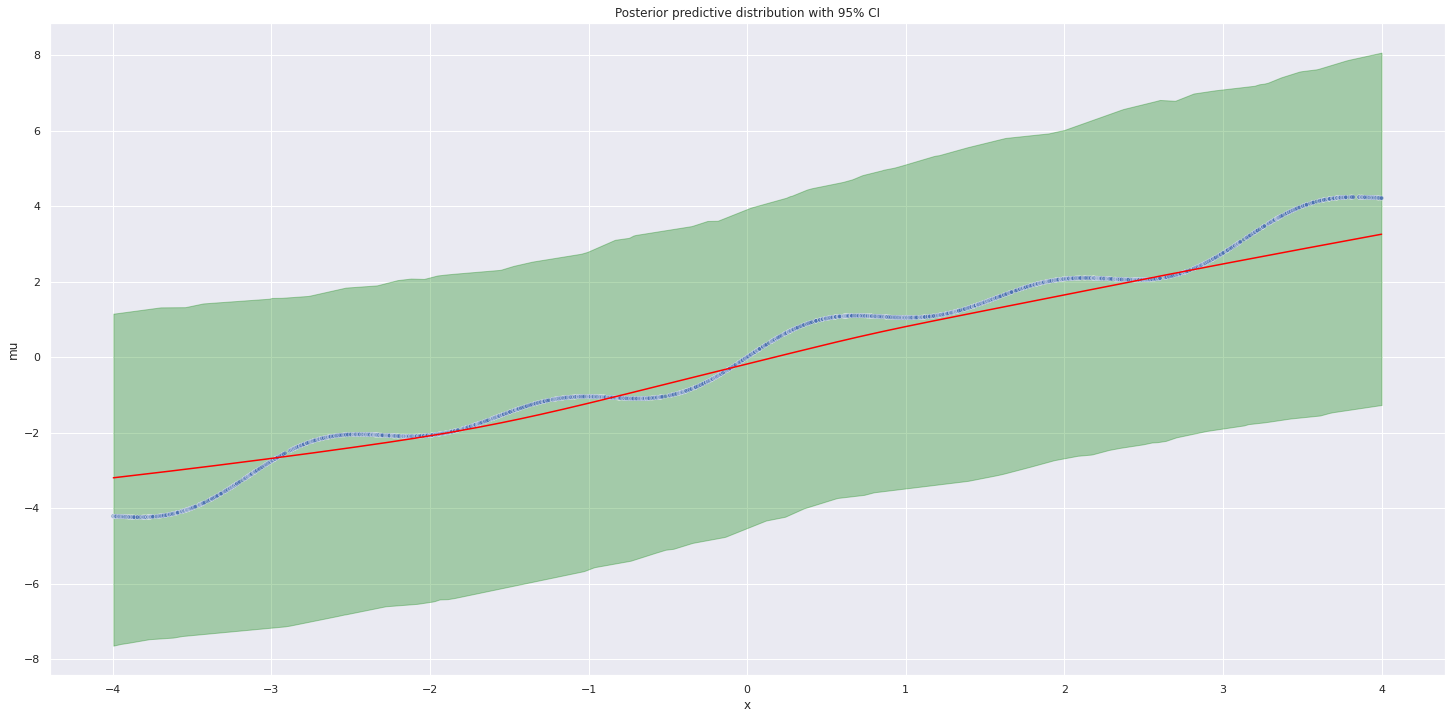

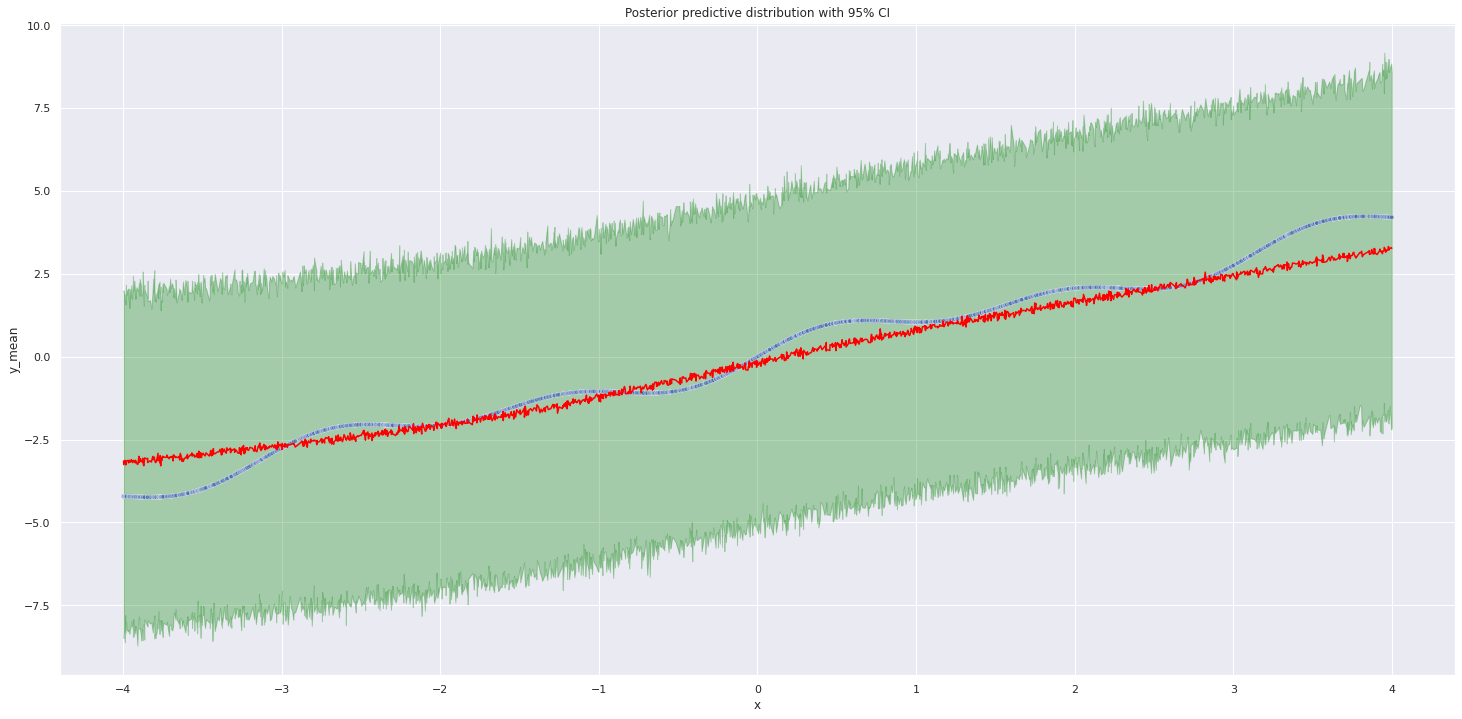

In [ ]:
plot_predictions(train_pred_sorted)
plot_predictions(test_pred_sorted)

Loaded model and parameters from ./experiments/sanity_check/models/sin-1x
using device: cpu
====== evaluating profile sin-1x ======
Eval done in 0:01:29.055331


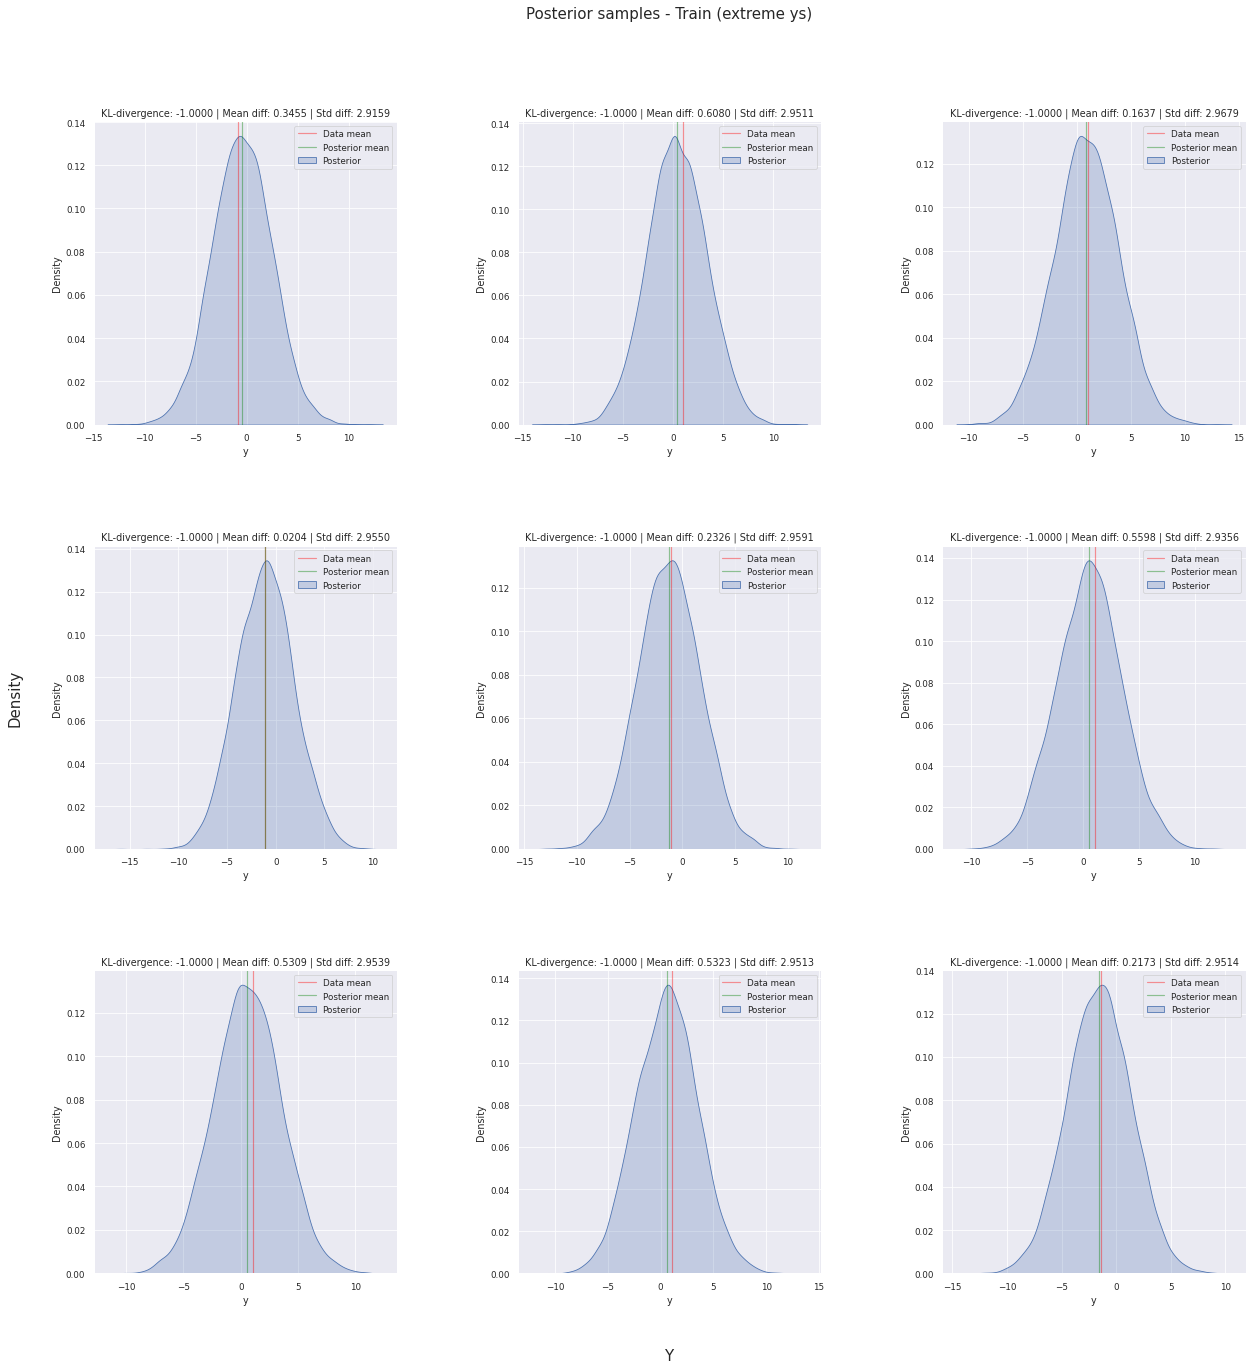

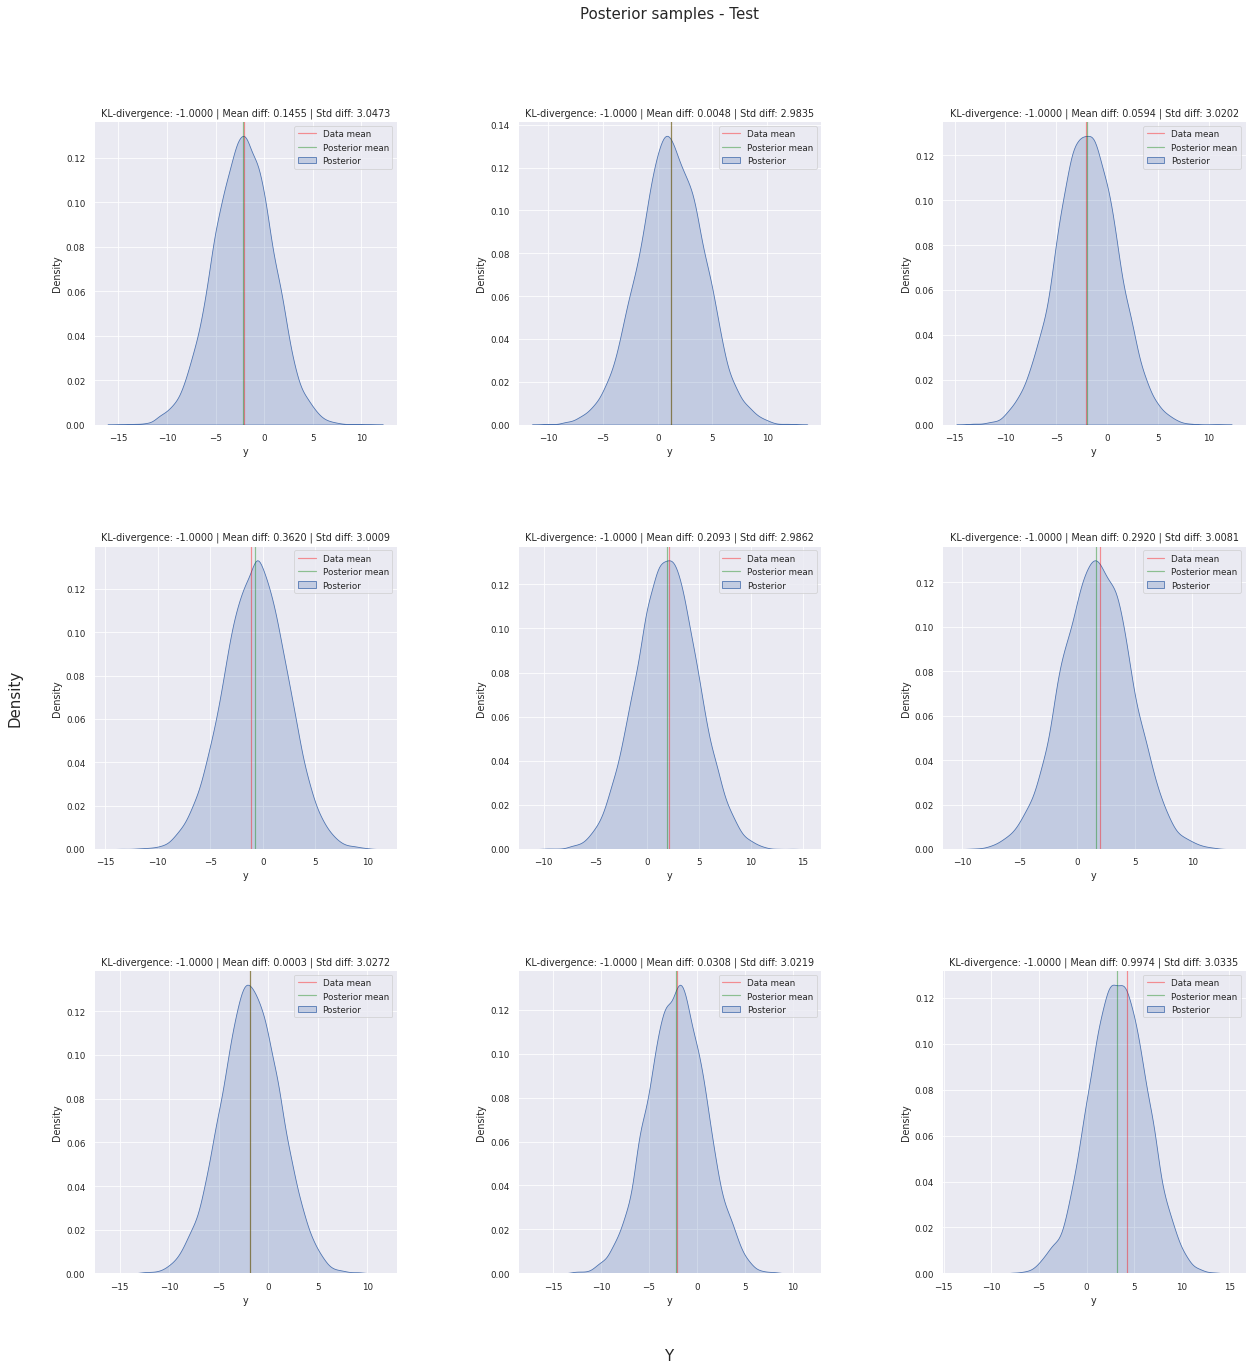

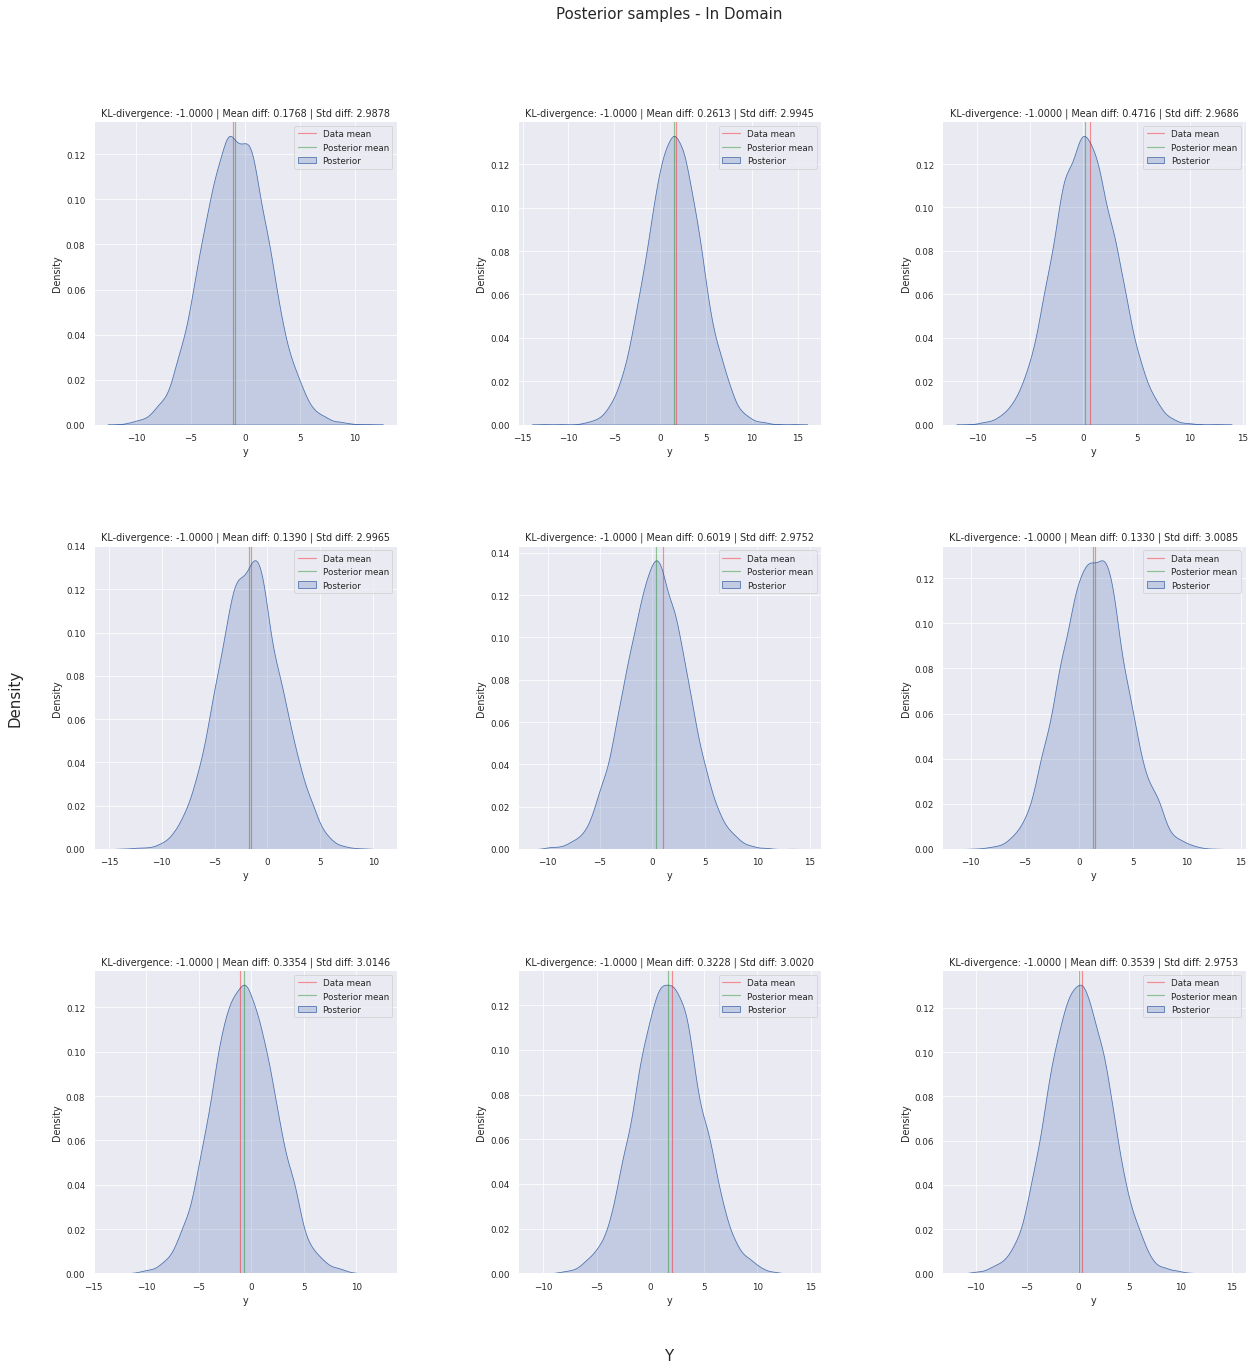

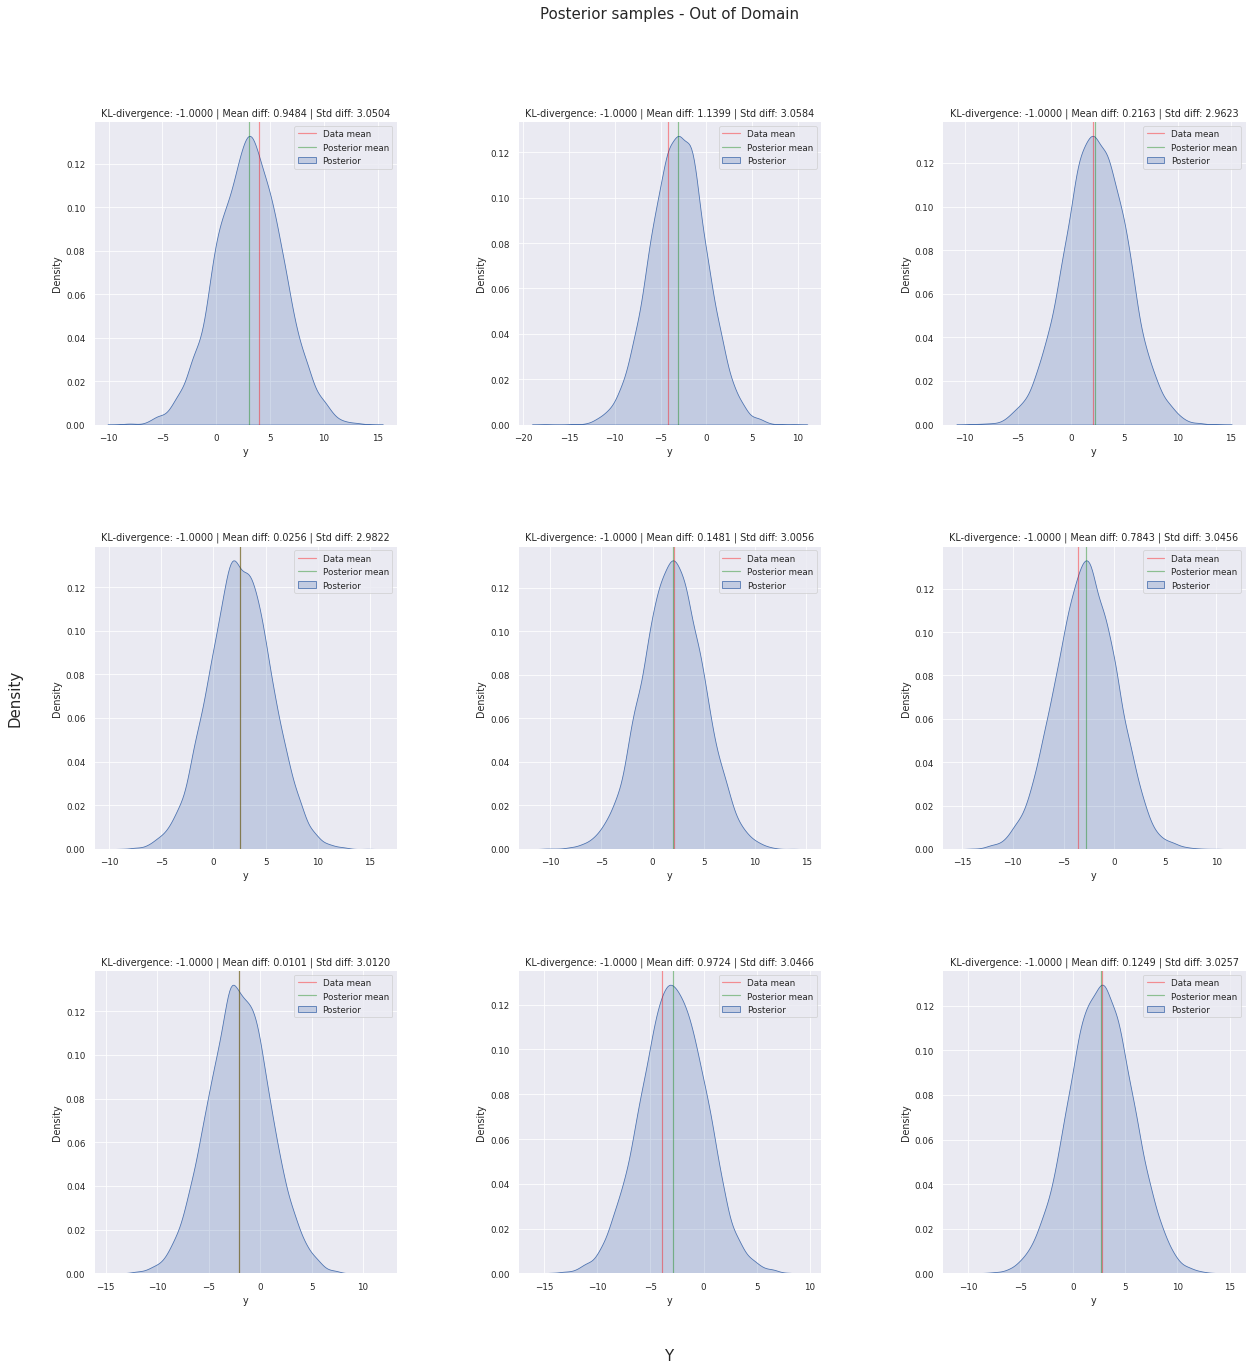

In [ ]:
if True:
            if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")

            eval.eval(config, dataset_config, f"{BASE_DIR}")